In [27]:
import os
from datetime import datetime
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

from utils.network_utils import configure_network_and_connect
from utils.contract_utils import init_contract

In [2]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}")

In [3]:
WEEK = 86400 * 7

In [4]:
distributor = init_contract("0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc")
tri_pool = init_contract("0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7")
t = int(time()) // WEEK * WEEK
virtual_price = tri_pool.get_virtual_price() / 1e18

Fetching source of 0xA464e6DCda8AC41e03616F95f4BC98a13b8922Dc from api.etherscan.io...


Get fees

In [5]:
output = []
while True:
    fees = distributor.tokens_per_week(t)
    if fees == 0 and len(output) > 0:
        break
    d = datetime.fromtimestamp(t)
    output.append((d, fees))
    t -= WEEK

if output[0][1] == 0:
    output = output[1:]

output

[(datetime.datetime(2022, 5, 5, 1, 0), 2576714390971898291844383),
 (datetime.datetime(2022, 4, 28, 1, 0), 767185552462084228559077),
 (datetime.datetime(2022, 4, 21, 1, 0), 936110188693318750688808),
 (datetime.datetime(2022, 4, 14, 1, 0), 2256885393968425347271123),
 (datetime.datetime(2022, 4, 7, 1, 0), 1108028777681494266526490),
 (datetime.datetime(2022, 3, 31, 1, 0), 893412561670021524029180),
 (datetime.datetime(2022, 3, 24, 0, 0), 1037475676248702731936142),
 (datetime.datetime(2022, 3, 17, 0, 0), 853238021074587113535327),
 (datetime.datetime(2022, 3, 10, 0, 0), 746142627137946559599853),
 (datetime.datetime(2022, 3, 3, 0, 0), 1168785207698885155038722),
 (datetime.datetime(2022, 2, 24, 0, 0), 1156916734403401804356455),
 (datetime.datetime(2022, 2, 17, 0, 0), 757034225031366958916474),
 (datetime.datetime(2022, 2, 10, 0, 0), 1001618192200810869311822),
 (datetime.datetime(2022, 2, 3, 0, 0), 987440182576220476571843),
 (datetime.datetime(2022, 1, 27, 0, 0), 3212993214245845389

In [15]:
dates = []
fees = []
for d, fee in output[::-1]:
    dates.append(d)
    fees.append(fee * virtual_price / 1e18)
    print("{0}|\t${1:.2f}".format(d, fees[-1]))

fees = np.array(fees)
dates = np.array(dates)
df_fees = pd.DataFrame(index=dates, data=fees, columns=['fees'])
df_fees

2020-09-17 01:00:00|	$274456.66
2020-09-24 01:00:00|	$274456.66
2020-10-01 01:00:00|	$274456.66
2020-10-08 01:00:00|	$274456.66
2020-10-15 01:00:00|	$274456.66
2020-10-22 01:00:00|	$274456.66
2020-10-29 00:00:00|	$274456.66
2020-11-05 00:00:00|	$274456.66
2020-11-12 00:00:00|	$274456.66
2020-11-19 00:00:00|	$274456.66
2020-11-26 00:00:00|	$274456.66
2020-12-03 00:00:00|	$259411.32
2020-12-10 00:00:00|	$249537.03
2020-12-17 00:00:00|	$211280.78
2020-12-24 00:00:00|	$278596.63
2020-12-31 00:00:00|	$674926.01
2021-01-07 00:00:00|	$440848.14
2021-01-14 00:00:00|	$435316.06
2021-01-21 00:00:00|	$416473.10
2021-01-28 00:00:00|	$389557.96
2021-02-04 00:00:00|	$2395421.90
2021-02-11 00:00:00|	$2668943.82
2021-02-18 00:00:00|	$738219.19
2021-02-25 00:00:00|	$619528.69
2021-03-04 00:00:00|	$1048003.69
2021-03-11 00:00:00|	$617120.71
2021-03-18 00:00:00|	$496685.75
2021-03-25 00:00:00|	$560123.40
2021-04-01 01:00:00|	$650977.27
2021-04-08 01:00:00|	$1076993.32
2021-04-15 01:00:00|	$845509.15
2021

,fees
2020-09-17 01:00:00,2.744567e+05
2020-09-24 01:00:00,2.744567e+05
2020-10-01 01:00:00,2.744567e+05
2020-10-08 01:00:00,2.744567e+05
2020-10-15 01:00:00,2.744567e+05
...,...
2022-04-07 01:00:00,1.131655e+06
2022-04-14 01:00:00,2.305009e+06
2022-04-21 01:00:00,9.560708e+05
2022-04-28 01:00:00,7.835442e+05


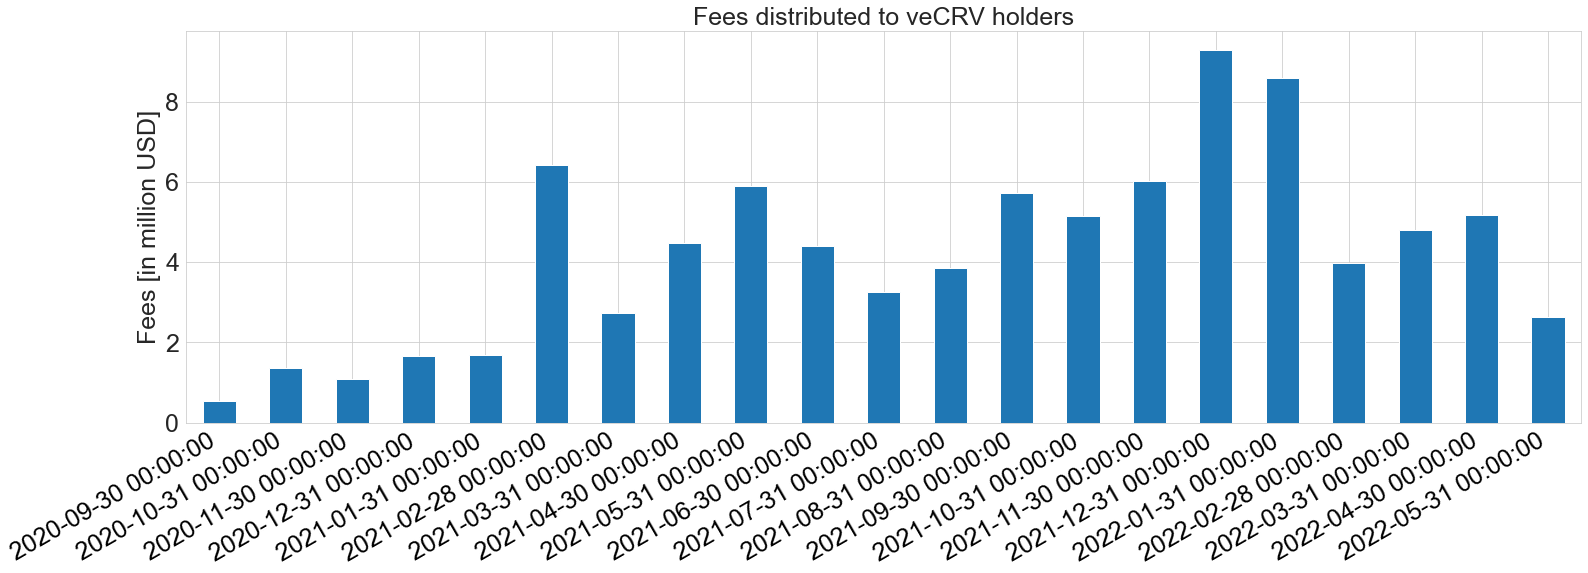

In [35]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

df_fees_truncated = df_fees.loc[df_fees.index > pd.Timestamp(2019, 1, 1)]
df_fees_truncated = df_fees_truncated.groupby(pd.Grouper(freq='1m')).sum()
(df_fees_truncated.fees*1e-6).plot(ax=ax, kind='bar')

ax.set_ylabel("Fees [in million USD]", fontsize=25)
ax.set_title("Fees distributed to veCRV holders", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', colors='black')
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)

# myFmt = mdates.DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(myFmt)

fig.autofmt_xdate()